In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Visualizing the data

In [2]:
data=pd.read_csv("train.csv")

data.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB


In [4]:
test_data=pd.read_csv("test.csv")
test_data.drop('id',inplace=True, axis='columns')

In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58921 entries, 0 to 58920
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   RESOURCE          58921 non-null  int64
 1   MGR_ID            58921 non-null  int64
 2   ROLE_ROLLUP_1     58921 non-null  int64
 3   ROLE_ROLLUP_2     58921 non-null  int64
 4   ROLE_DEPTNAME     58921 non-null  int64
 5   ROLE_TITLE        58921 non-null  int64
 6   ROLE_FAMILY_DESC  58921 non-null  int64
 7   ROLE_FAMILY       58921 non-null  int64
 8   ROLE_CODE         58921 non-null  int64
dtypes: int64(9)
memory usage: 4.0 MB


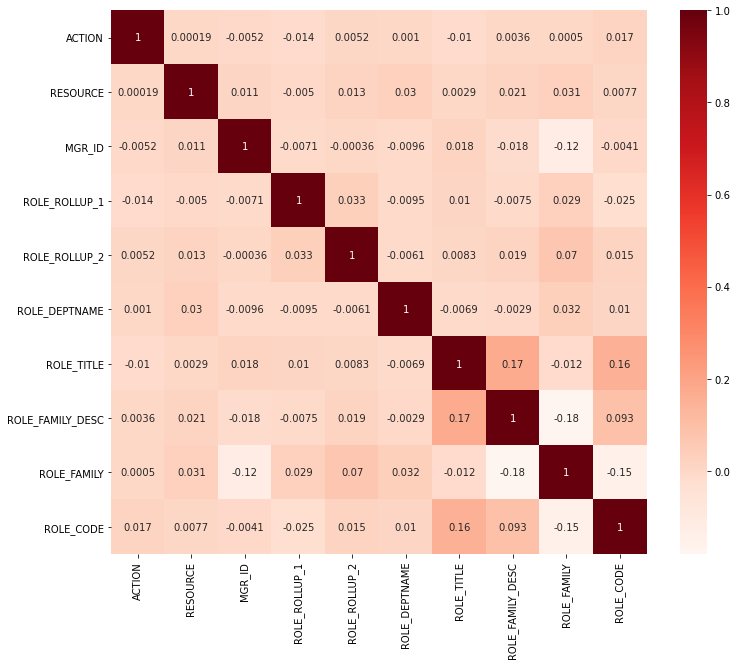

In [6]:
import seaborn as sns

plt.figure(figsize=(12,10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

### We can see that the features are not closely corelated.

# Modeling

In [7]:
X=data.iloc[:,1:]
y=data.iloc[:,0]

X.head()

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,42680,5905,117929,117930,119569,119323,123932,19793,119325


### Normalizing the data by feature scaling.

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X)
X = scaler.transform(X)
test_data = scaler.transform(test_data)

In [9]:
y.isin([1]).sum(axis=0)

30872

In [10]:
y.isin([0]).sum(axis=0)

1897

### We can see that the data is not balanced, observations corresponding to zero are way less than observations corresponding to one. So I used stratified train-test split for modelling.

In [11]:
import sklearn
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.9,stratify=y,random_state=42,shuffle=True)

### I tested few models like Decision Tree, Logistic Regression, Naive Bayes, etc. and Decision Tree Classifier performed the best.

## Optimising the Decision Tree Classifier

In [12]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

depth_range = [50,100,150,200,250,300,350,400]
auc_value = []
for depth in depth_range:
    clf = DecisionTreeClassifier(criterion="entropy",max_depth = depth)
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred,pos_label=1)
    score = metrics.auc(fpr,tpr)
    auc_value.append(score)

Text(0, 0.5, 'Area Under ROC Curve')

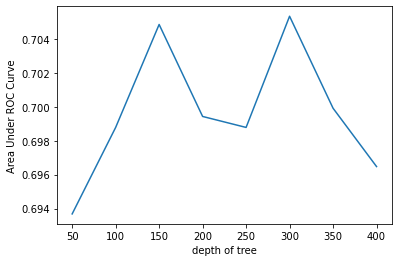

In [13]:
plt.plot(depth_range, auc_value)

plt.xlabel('depth of tree')
plt.ylabel('Area Under ROC Curve')

In [14]:
max_y = max(auc_value)  
max_x = depth_range[auc_value.index(max_y)]  
print(max_x,max_y)

300 0.7053415852556562


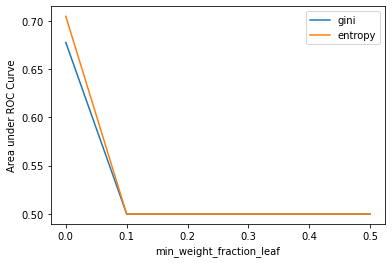

In [15]:
fractions = [0,0.1,0.2,0.3,0.4,0.5]

min_weight_fraction_leaf = []
acc_gini = []
acc_entropy = []

for i in fractions:
    clf = DecisionTreeClassifier(criterion="gini", min_weight_fraction_leaf=i,max_depth=max_x)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test,pred,pos_label=1)
    score = metrics.auc(fpr,tpr)
    acc_gini.append(score)
 
    clf = DecisionTreeClassifier(criterion='entropy',min_weight_fraction_leaf=i,max_depth=max_x)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test,pred,pos_label=1)
    score = metrics.auc(fpr,tpr)
    acc_entropy.append(score)
    
plt.plot(fractions,acc_gini, label='gini')
plt.plot(fractions,acc_entropy,  label='entropy')
plt.xlabel('min_weight_fraction_leaf')
plt.ylabel('Area under ROC Curve')
plt.legend()

### The tree performs slightly better for criterion="entropy" and best for min_weight_fraction_leaf=0

In [16]:
clf = DecisionTreeClassifier(criterion="entropy",max_depth=max_x,min_weight_fraction_leaf=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

## Results on Test Data

In [17]:
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred , pos_label=1)
auc = metrics.auc(fpr,tpr)
print(auc)

0.6966370006649276


<AxesSubplot:>

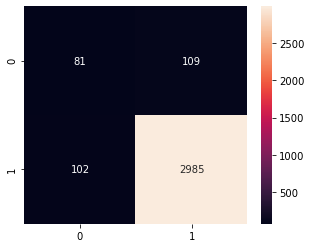

In [18]:
from sklearn.metrics import confusion_matrix
array=confusion_matrix(y_test,y_pred)

df_cm = pd.DataFrame(array, index = [i for i in range(2)],columns = [i for i in range(2)])
ax=plt.figure(figsize = (5,4))
sns.heatmap(df_cm, annot=True,fmt='g') 

In [19]:
from sklearn.metrics import classification_report

report=classification_report(y_test,y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.44      0.43      0.43       190
           1       0.96      0.97      0.97      3087

    accuracy                           0.94      3277
   macro avg       0.70      0.70      0.70      3277
weighted avg       0.93      0.94      0.94      3277



## Submission file

In [20]:
Y_predicted = clf.predict(test_data)
y_predicted = pd.DataFrame(Y_predicted)
y_predicted.columns = ['ACTION']
y_predicted.insert(loc=0, column='id', value=(y_predicted.index))
y_predicted['id'] += 1
y_predicted.to_csv("Submission.csv",index = False)

### After Submission on kaggle, I got area under ROC curve around 0.69